In [1]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-03-11T21:30:38.733144Z","iopub.execute_input":"2024-03-11T21:30:38.733548Z","iopub.status.idle":"2024-03-11T21:30:38.742529Z","shell.execute_reply.started":"2024-03-11T21:30:38.733517Z","shell.execute_reply":"2024-03-11T21:30:38.741123Z"}}
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from skimage.transform import resize
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model

In [2]:
# %% [markdown]
# Read training images and labels 

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:41.098288Z","iopub.execute_input":"2024-03-11T21:30:41.099432Z","iopub.status.idle":"2024-03-11T21:30:41.105973Z","shell.execute_reply.started":"2024-03-11T21:30:41.099383Z","shell.execute_reply":"2024-03-11T21:30:41.104325Z"}}
def get_dataset_path():
    # Check if running in Kaggle
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        # Running in Kaggle kernel
        return '/kaggle/input/machine-learning-in-science-ii-2024'
    else:
        # Running in a standalone Python script
        return Path(__file__).parent



In [3]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:42.301523Z","iopub.execute_input":"2024-03-11T21:30:42.301940Z","iopub.status.idle":"2024-03-11T21:30:42.308772Z","shell.execute_reply.started":"2024-03-11T21:30:42.301911Z","shell.execute_reply":"2024-03-11T21:30:42.307347Z"}}
# Example usage:
dataset_path = get_dataset_path()
print(f"Dataset path: {dataset_path}")
print(f"{dataset_path}/training_data/training_data")
print(f"{dataset_path}/test_data/test_data")

Dataset path: /kaggle/input/machine-learning-in-science-ii-2024
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data
/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data


In [4]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:42.621016Z","iopub.execute_input":"2024-03-11T21:30:42.621469Z","iopub.status.idle":"2024-03-11T21:30:42.628971Z","shell.execute_reply.started":"2024-03-11T21:30:42.621434Z","shell.execute_reply":"2024-03-11T21:30:42.627579Z"}}
def construct_images_path(directory_with_images):
    filenames = os.listdir(directory_with_images) 
    image_paths = []
    if any ('.png' in filename for filename in filenames):
        for index, current_filename in enumerate(filenames):
            image_path = f"{directory_with_images}/{current_filename}"
            image_paths.append(image_path)
            
    return image_paths


#construct_images_path(f"{dataset_path}/training_data/training_data")

In [5]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:43.878043Z","iopub.execute_input":"2024-03-11T21:30:43.878435Z","iopub.status.idle":"2024-03-11T21:30:43.883261Z","shell.execute_reply.started":"2024-03-11T21:30:43.878406Z","shell.execute_reply":"2024-03-11T21:30:43.882051Z"}}
def build_training_directory_img(dataset_directory):
    return f"{dataset_directory}/training_data/training_data"

In [6]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:44.087400Z","iopub.execute_input":"2024-03-11T21:30:44.087814Z","iopub.status.idle":"2024-03-11T21:30:44.094046Z","shell.execute_reply.started":"2024-03-11T21:30:44.087784Z","shell.execute_reply":"2024-03-11T21:30:44.093064Z"}}
def build_test_directory_img(dataset_directory):
    return f"{dataset_directory}/test_data/test_data"

In [7]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:46.474191Z","iopub.execute_input":"2024-03-11T21:30:46.474610Z","iopub.status.idle":"2024-03-11T21:30:46.502230Z","shell.execute_reply.started":"2024-03-11T21:30:46.474579Z","shell.execute_reply":"2024-03-11T21:30:46.500284Z"}}
def build_images_path(dataset_directory):
    training_images_directory = build_training_directory_img(dataset_directory)
    test_images_directory = build_test_directory_img(dataset_directory)
    training_images_path = construct_images_path(training_images_directory)
    test_images_path = construct_images_path(test_images_directory)
    return training_images_path,test_images_path

train_img, test_img = build_images_path(dataset_path)
# print(train_img) # print list with all images.
print(f"Dataset path: \n{train_img[0]} \n{test_img[0]}")

Dataset path: 
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9273.png 
/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data/1017.png


In [8]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:49.224761Z","iopub.execute_input":"2024-03-11T21:30:49.225184Z","iopub.status.idle":"2024-03-11T21:30:49.244336Z","shell.execute_reply.started":"2024-03-11T21:30:49.225151Z","shell.execute_reply":"2024-03-11T21:30:49.242928Z"}}
def get_csv_labels(dataset_directory):
    training_labels_relative_path = f"{dataset_directory}/training_norm.csv" # data frame path
    training_labels = pd.read_csv(training_labels_relative_path)   # store the labels
    return training_labels

training_labels = get_csv_labels(dataset_path)
print(training_labels)

       image_id   angle  speed
0             1  0.4375    0.0
1             2  0.8125    1.0
2             3  0.4375    1.0
3             4  0.6250    1.0
4             5  0.5000    0.0
...         ...     ...    ...
13788     13794  0.6250    1.0
13789     13795  0.4375    1.0
13790     13796  0.5625    0.0
13791     13797  0.6250    0.0
13792     13798  0.6875    1.0

[13793 rows x 3 columns]


In [9]:
# %% [markdown]
# # Preprocessing.
# Removing corrupted images.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:30:51.665049Z","iopub.execute_input":"2024-03-11T21:30:51.665552Z","iopub.status.idle":"2024-03-11T21:31:03.388716Z","shell.execute_reply.started":"2024-03-11T21:30:51.665503Z","shell.execute_reply":"2024-03-11T21:31:03.387750Z"}}
def find_corrupted_images(image_paths):
    corrupted_indices = []
    #print(image_paths)

    for i, image_path in enumerate(image_paths):
        try:
            # Attempt to open the image
            with Image.open(image_path) as img:
                # Perform any additional checks if needed
                pass
        except (IOError, OSError, Exception) as e:
            # Extract the index from the image_path
            index = int(image_path.split('/')[-1].split('.png')[0])
            # Handle the error (consider the image as corrupted)
            print(f"Error opening image {index}.png: {e}")
            corrupted_indices.append(index)
    return corrupted_indices

# Find corrupted images
corrupted_indices = find_corrupted_images(train_img)

# Print the indices of corrupted images
print("Corrupted Image Indices:", corrupted_indices)

Error opening image 10171.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10171.png'
Error opening image 3141.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3141.png'
Error opening image 3999.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3999.png'
Error opening image 4895.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4895.png'
Error opening image 8285.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/8285.png'
Corrupted Image Indices: [10171, 3141, 3999, 4895, 8285]


In [10]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:03.390559Z","iopub.execute_input":"2024-03-11T21:31:03.391465Z","iopub.status.idle":"2024-03-11T21:31:03.420994Z","shell.execute_reply.started":"2024-03-11T21:31:03.391433Z","shell.execute_reply":"2024-03-11T21:31:03.419836Z"}}
print(len(train_img))
training_labels_test = get_csv_labels(dataset_path)
# Manual check if we removed the image IDs:
image_ids_to_check = [3884, 10171, 3141, 3999, 4895, 8285 , 1017, 13139, 13786, 13782          ]
print(training_labels_test)

# Check if the image IDs exist in the list of cleaned image paths
for image_id in image_ids_to_check:
    
    filename_to_check = f'/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/{image_id}.png'
    if filename_to_check in train_img:
        
        print(f"The file path for {filename_to_check} exists in the list.")
    else:
        print(f"The file path for {filename_to_check} does not exist in the list.")

# Check if the image IDs exist in the DataFrame
for image_id in image_ids_to_check:
    # Check if the image ID exists in the 'image_id' column of data_labels_cleaned2
    if image_id in training_labels_test['image_id'].tolist():
        print(f"The image ID {image_id} exists in training_labels_test.")
    else:
        print(f"The image ID {image_id} does not exist in training_labels_test.")

13798
       image_id   angle  speed
0             1  0.4375    0.0
1             2  0.8125    1.0
2             3  0.4375    1.0
3             4  0.6250    1.0
4             5  0.5000    0.0
...         ...     ...    ...
13788     13794  0.6250    1.0
13789     13795  0.4375    1.0
13790     13796  0.5625    0.0
13791     13797  0.6250    0.0
13792     13798  0.6875    1.0

[13793 rows x 3 columns]
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3884.png exists in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10171.png exists in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3141.png exists in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3999.png exists in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data

In [11]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:08.289378Z","iopub.execute_input":"2024-03-11T21:31:08.289849Z","iopub.status.idle":"2024-03-11T21:31:08.297132Z","shell.execute_reply.started":"2024-03-11T21:31:08.289813Z","shell.execute_reply":"2024-03-11T21:31:08.295832Z"}}
def remove_corrupted_data_labels(training_labels, corrupted_indices):
    # Remove corrupted data from original data label set (training_norm.csv)
    # Extract the 'image_id' column from the original DataFrame
    image_ids = training_labels['image_id']
    
    # Identify the 'image_id' values for the corrupted images
    corrupted_image_ids = image_ids.iloc[corrupted_indices].tolist()

    # Check if each 'image_id' is in the list of corrupted 'image_id' values
    is_not_corrupted = ~image_ids.isin(corrupted_image_ids)

    # Filter the original DataFrame
    data_labels_cleaned = training_labels[is_not_corrupted]

    # Reset the index of the cleaned DataFrame
    data_labels_cleaned = data_labels_cleaned.reset_index(drop=True)
    
    return data_labels_cleaned

In [12]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:09.154695Z","iopub.execute_input":"2024-03-11T21:31:09.155103Z","iopub.status.idle":"2024-03-11T21:31:09.161957Z","shell.execute_reply.started":"2024-03-11T21:31:09.155071Z","shell.execute_reply":"2024-03-11T21:31:09.161069Z"}}
def remove_corrupted_data_images(dataset_directory, image_paths, corrupted_indices ):
    # Remove corrupted images from original path list images:
    # Remove corresponding image paths for corrupted images
    training_images_directory = build_training_directory_img(dataset_directory)
    filenames = os.listdir(training_images_directory)

    # Initialize a list to store cleaned image paths
    image_paths_cleaned = []

    for current_filename in filenames:
        image_id = int(current_filename.split('.')[0])
        
        # Check if the image_id is not in the list of corrupted indices
        if image_id not in corrupted_indices:
            image_path = os.path.join(training_images_directory, current_filename)
            image_paths_cleaned.append(image_path)
    return image_paths_cleaned

In [13]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:10.176513Z","iopub.execute_input":"2024-03-11T21:31:10.176963Z","iopub.status.idle":"2024-03-11T21:31:10.238428Z","shell.execute_reply.started":"2024-03-11T21:31:10.176927Z","shell.execute_reply":"2024-03-11T21:31:10.237121Z"}}
def remove_corrupted_data(dataset_directory, training_labels, image_paths, corrupted_indices):
    # Remove corrupted data from original data label set (training_norm.csv)
    data_labels_cleaned = remove_corrupted_data_labels(training_labels, corrupted_indices)
    # Remove corrupted images from original path list images:
    image_paths_cleaned = remove_corrupted_data_images(dataset_directory, image_paths, corrupted_indices)
    
    # Return cleaned DataFrame and image paths
    return data_labels_cleaned, image_paths_cleaned

# Example usage


data_labels_cleaned, image_paths_cleaned = remove_corrupted_data(dataset_path, training_labels, train_img, corrupted_indices)

print(f'Labels: new:{len(data_labels_cleaned)} - old:{len(training_labels)}')
print(f'Images: new:{len(image_paths_cleaned)} - old:{len(train_img)}')


Labels: new:13788 - old:13793
Images: new:13793 - old:13798


In [14]:
# %% [markdown]
# Check for incorect data.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:38:20.186941Z","iopub.execute_input":"2024-03-11T21:38:20.187392Z","iopub.status.idle":"2024-03-11T21:38:24.155637Z","shell.execute_reply.started":"2024-03-11T21:38:20.187359Z","shell.execute_reply":"2024-03-11T21:38:24.154217Z"}}
def remove_invalid_speed_data(data_labels, image_paths):
    # Filter rows where 'speed' is not 0 or 1
  
    invalid_speed_filter = (data_labels['speed'] != 0) & (data_labels['speed'] != 1)
    invalid_speed_rows = data_labels[invalid_speed_filter]
    print(f'Removed rows with invalid speed values:\n{invalid_speed_rows}')

    # Get the indices of removed rows
    removed_indices = invalid_speed_rows.index.tolist()
    print(f'Indices of removed rows: {removed_indices}')

    # Print the 'image_id' values of removed rows
    removed_image_ids = invalid_speed_rows['image_id'].tolist()
    print(f'Image_id values of removed rows: {removed_image_ids}')

    # Filter rows where 'speed' is not 0 or 1
    valid_speed_rows = data_labels[~invalid_speed_filter]

    # Extract the 'image_id' column from valid speed rows
    valid_image_ids = valid_speed_rows['image_id'].tolist()
    print(f"Number of entries with valid 'speed' values: {len(valid_speed_rows)}")
    # Filter image_paths based on valid image_ids
    cleaned_image_paths = [path for path in image_paths if int(path.split('/')[-1].split('.')[0]) in valid_image_ids]
     # Print paths that are not in cleaned_image_paths
    not_included_paths = [path for path in image_paths if path not in cleaned_image_paths]
    print(f'Paths not included in cleaned_image_paths:')
    for path in not_included_paths:
        print(path)
    
    # Return cleaned DataFrame and corresponding image paths
    return valid_speed_rows, cleaned_image_paths

data_labels_cleaned2, image_paths_cleaned2 = remove_invalid_speed_data(data_labels_cleaned, image_paths_cleaned)
print(f': Labels: New count:{len(data_labels_cleaned2)} ? Previous count:{len(data_labels_cleaned)}')
print(f': Images: New count:{len(image_paths_cleaned2)} ? Previous count:{len(image_paths_cleaned)}')
print(f"Type of image_paths_cleaned2 {type(image_paths_cleaned2)}.")

Removed rows with invalid speed values:
      image_id   angle     speed
3881      3884  0.4375  1.428571
Indices of removed rows: [3881]
Image_id values of removed rows: [3884]
Number of entries with valid 'speed' values: 13787
Paths not included in cleaned_image_paths:
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3884.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3143.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/8290.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4899.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4002.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10177.png
: Labels: New count:13787 ? Previous count:13788
: Images: New count:13787 ? Previous count:13793
Type of image_paths_cleaned2 <class 'list'>.


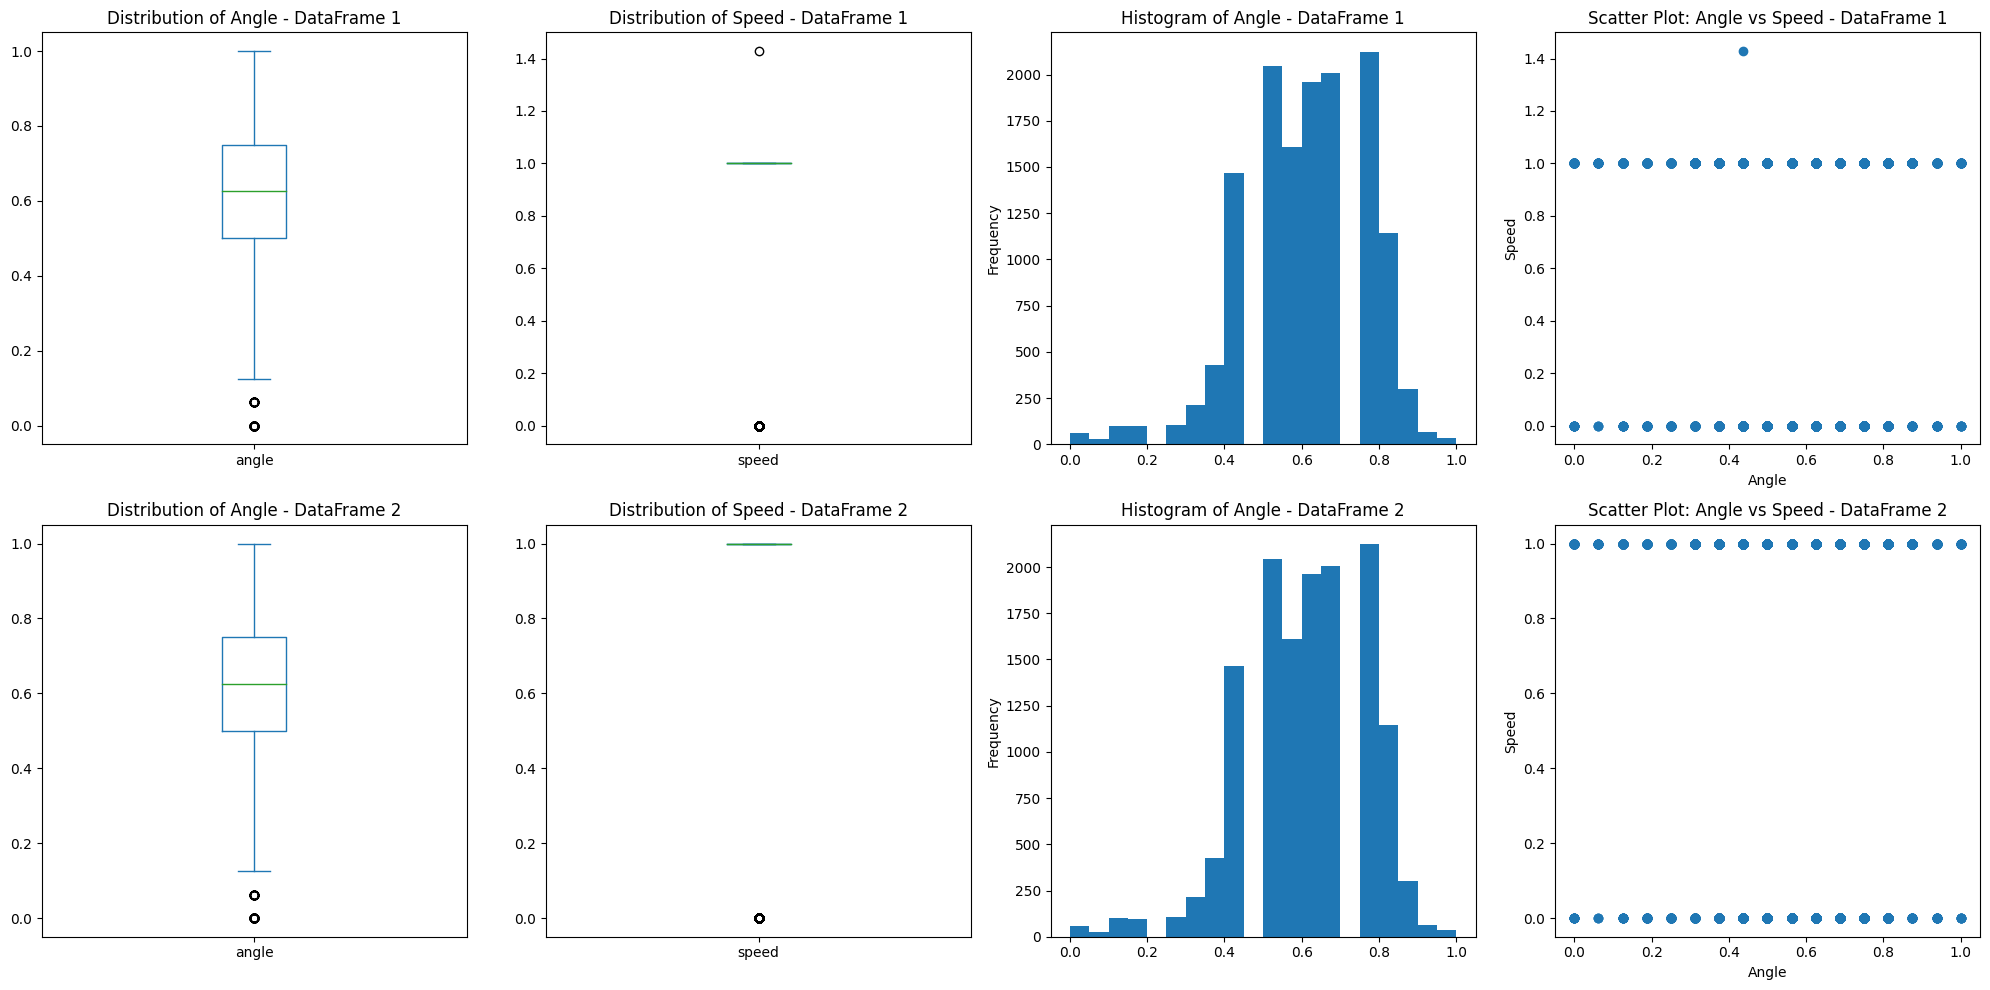

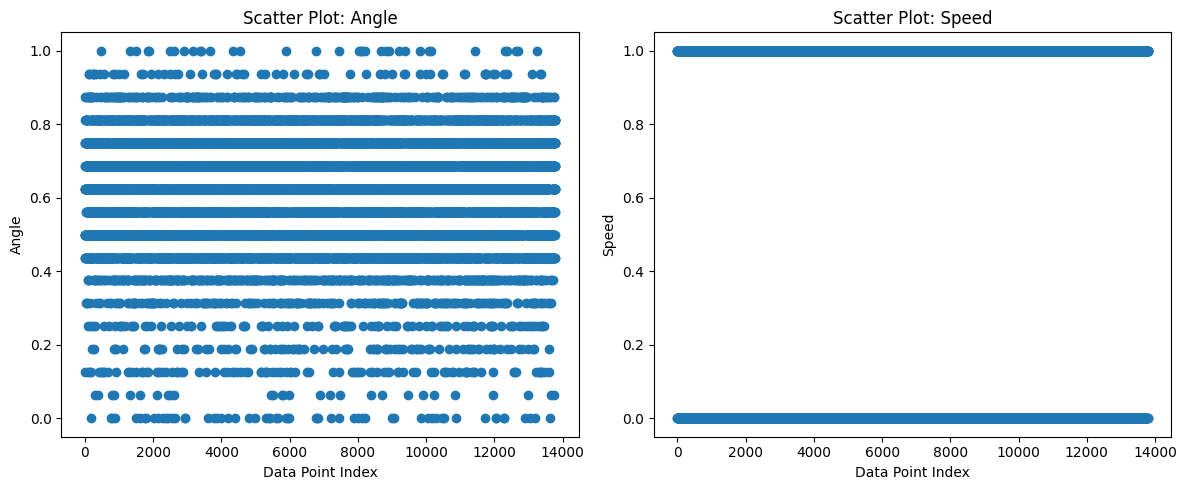

In [15]:
# %% [markdown]
# # Plot Visual Inspection: 

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:20.779432Z","iopub.execute_input":"2024-03-11T21:31:20.779842Z","iopub.status.idle":"2024-03-11T21:31:23.649305Z","shell.execute_reply.started":"2024-03-11T21:31:20.779809Z","shell.execute_reply":"2024-03-11T21:31:23.648191Z"}}
# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot the first box plot for 'angle'
data_labels_cleaned['angle'].plot(kind='box', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Angle - DataFrame 1')

# Plot the first box plot for 'speed'
data_labels_cleaned['speed'].plot(kind='box', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Speed - DataFrame 1')

# Histogram for 'angle' in DataFrame 1
data_labels_cleaned['angle'].plot(kind='hist', bins=20, ax=axes[0, 2])
axes[0, 2].set_title('Histogram of Angle - DataFrame 1')

# Scatter plot of 'angle' against 'speed' in DataFrame 1
axes[0, 3].scatter(data_labels_cleaned['angle'], data_labels_cleaned['speed'])
axes[0, 3].set_title('Scatter Plot: Angle vs Speed - DataFrame 1')
axes[0, 3].set_xlabel('Angle')
axes[0, 3].set_ylabel('Speed')

# Plot the second box plot for 'angle'
data_labels_cleaned2['angle'].plot(kind='box', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Angle - DataFrame 2')

# Plot the second box plot for 'speed'
data_labels_cleaned2['speed'].plot(kind='box', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Speed - DataFrame 2')

# Histogram for 'angle' in DataFrame 2
data_labels_cleaned2['angle'].plot(kind='hist', bins=20, ax=axes[1, 2])
axes[1, 2].set_title('Histogram of Angle - DataFrame 2')

# Scatter plot of 'angle' against 'speed' in DataFrame 2
axes[1, 3].scatter(data_labels_cleaned2['angle'], data_labels_cleaned2['speed'])
axes[1, 3].set_title('Scatter Plot: Angle vs Speed - DataFrame 2')
axes[1, 3].set_xlabel('Angle')
axes[1, 3].set_ylabel('Speed')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for 'angle'
axes[0].scatter(range(len(data_labels_cleaned2['angle'])), data_labels_cleaned2['angle'])
axes[0].set_title('Scatter Plot: Angle')
axes[0].set_xlabel('Data Point Index')
axes[0].set_ylabel('Angle')

# Scatter plot for 'speed'
axes[1].scatter(range(len(data_labels_cleaned2['speed'])), data_labels_cleaned2['speed'])
axes[1].set_title('Scatter Plot: Speed')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Speed')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [16]:
# %% [markdown]
# # CNN MODEL
# 

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:50:44.074295Z","iopub.execute_input":"2024-03-11T22:50:44.074788Z","iopub.status.idle":"2024-03-11T22:50:44.090998Z","shell.execute_reply.started":"2024-03-11T22:50:44.074754Z","shell.execute_reply":"2024-03-11T22:50:44.089736Z"}}
def create_cnn_model_v3(image_shape, pool_size=(2, 2)):
    """
    Creates two CNN models with the specified input shape.
    """
    model_speed = Sequential([
        Input(shape=image_shape + (3,), name='input_speed'),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(256, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', name='output_speed')  # Output layer for 'speed'
    ], name='model_speed')

    model_angle = Sequential([
        Input(shape=image_shape + (3,), name='input_angle'),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(256, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear', name='output_angle')  # Output layer for 'angle'
    ], name='model_angle')

    print("Model Speed Summary:")
    model_speed.summary()
    
    print("\nModel Angle Summary:")
    model_angle.summary()
    
    return model_speed, model_angle

In [17]:
# %% [markdown]
# # Data Generator class.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:36:57.012506Z","iopub.execute_input":"2024-03-11T21:36:57.012948Z","iopub.status.idle":"2024-03-11T21:36:57.032538Z","shell.execute_reply.started":"2024-03-11T21:36:57.012917Z","shell.execute_reply":"2024-03-11T21:36:57.031148Z"}}
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, image_shape, output_label, augmentations=None, shuffle=True):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.output_label = output_label
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_paths))


    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_paths = self.file_paths[start:end]

        # Extract 'angle' or 'speed' column from the DataFrame as the batch labels
        batch_labels = self.labels[self.output_label].iloc[start:end].values  

        images = [self.load_and_augment_image(file_path) for file_path in batch_paths]
        images = np.array(images)
        output_values = np.array(batch_labels)  # Assign labels to output_values

        return images, {self.output_label: output_values}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_and_augment_image(self, file_path):
        try:
            # Load the image
            img = load_img(file_path, target_size=self.image_shape)

            # Ensure the image is in RGB format
            img = img.convert("RGB") # Convert to 3 channels image 

            # Convert the image to a NumPy array
            img_array = img_to_array(img)

            # Resize the image to the target size before augmentations
            img_array = resize(img_array, self.image_shape)

            # Print image shape before augmentations
            #print(f"Image shape before augmentations: {img_array.shape}")

            # Apply augmentations if specified
            if self.augmentations:
                img_array = self.augmentations.random_transform(img_array)

            # Print image shape after augmentations
            #print(f"Image shape after augmentations: {img_array.shape}")

            # Normalize to [0, 1]
            img_array = img_array / 255.0

            return img_array
        except Exception as e:
            # Handle the exception (skip problematic image)
            print(f"Error loading image at path {file_path}: {e}")
            return None #self.placeholder  # 
        
    def __iter__(self):
            # Reset the generator at the beginning of each epoch
            self.on_epoch_end()
            return self

    def __next__(self):
            # Generate batches during iteration
            index = 0
            while index < len(self):
                batch = self[index]
                index += 1
                return batch


# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:28.774114Z","iopub.execute_input":"2024-03-11T21:31:28.774525Z","iopub.status.idle":"2024-03-11T21:31:28.781590Z","shell.execute_reply.started":"2024-03-11T21:31:28.774495Z","shell.execute_reply":"2024-03-11T21:31:28.780144Z"}}
def create_data_generator(data_set, label_set, batch_size, image_shape, augmentations=None, output_label='speed'):  # if we don't specify the output_label, by default the output_label is speed.
    return CustomDataGenerator(data_set, label_set, batch_size, image_shape, output_label, augmentations)

In [18]:

# %% [markdown]
# # Test dataset.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:31:30.232388Z","iopub.execute_input":"2024-03-11T21:31:30.232836Z","iopub.status.idle":"2024-03-11T21:31:30.256388Z","shell.execute_reply.started":"2024-03-11T21:31:30.232801Z","shell.execute_reply":"2024-03-11T21:31:30.255247Z"}}
print(len(image_paths_cleaned2))

# Manual check if we removed the image IDs:
image_ids_to_check = [3884, 10171, 3141, 3999, 4895, 8285 , 1017, 13139, 13786, 13782          ]
print(data_labels_cleaned2)

# Check if the image IDs exist in the list of cleaned image paths
for image_id in image_ids_to_check:
    
    filename_to_check = f'/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/{image_id}.png'
    if filename_to_check in image_paths_cleaned2:
        
        print(f"The file path for {filename_to_check} exists in the list.")
    else:
        print(f"The file path for {filename_to_check} does not exist in the list.")

# Check if the image IDs exist in the DataFrame
for image_id in image_ids_to_check:
    # Check if the image ID exists in the 'image_id' column of data_labels_cleaned2
    if image_id in data_labels_cleaned2['image_id'].tolist():
        print(f"The image ID {image_id} exists in data_labels_cleaned2.")
    else:
        print(f"The image ID {image_id} does not exist in data_labels_cleaned2.")

13787
       image_id   angle  speed
0             1  0.4375    0.0
1             2  0.8125    1.0
2             3  0.4375    1.0
3             4  0.6250    1.0
4             5  0.5000    0.0
...         ...     ...    ...
13783     13794  0.6250    1.0
13784     13795  0.4375    1.0
13785     13796  0.5625    0.0
13786     13797  0.6250    0.0
13787     13798  0.6875    1.0

[13787 rows x 3 columns]
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3884.png does not exist in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10171.png does not exist in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3141.png does not exist in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3999.png does not exist in the list.
The file path for /kaggle/input/machine-learning-in-science-ii-

In [19]:

# %% [markdown]
# # Training

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:51:06.724218Z","iopub.execute_input":"2024-03-11T22:51:06.724700Z","iopub.status.idle":"2024-03-11T22:51:06.735776Z","shell.execute_reply.started":"2024-03-11T22:51:06.724656Z","shell.execute_reply":"2024-03-11T22:51:06.734302Z"}}
def build_training_validation_and_evaluation_sets(train_image_paths, data_labels, image_shape, batch_size, eval_split, train_val_split):


    # Split into training and validation sets our data set [images and labels]
    train_set, val_set, train_labels, val_labels = train_test_split(
        train_image_paths,
        data_labels,
        test_size=train_val_split[1],
        random_state=42, # 42 is a random value 
        #stratify=data_labels['speed'] # We want to make sure that we have similar distribution of of the target variable ('speed') 
                                      # is similar in both the training and validation sets.
    )
  
    # Split validation set into evaluation sets for speed and angle
    eval_set_speed, eval_set_angle, eval_labels_speed, eval_labels_angle = train_test_split(
        val_set,
        val_labels,
        test_size=eval_split,
        random_state=42, # 42 is a random value 
        #stratify=data_labels['speed'] # We want to make sure that we have similar distribution of of the target variable ('speed') 
                                      # is similar in both the training and validation sets.
    )
   # Additional processing as needed (e.g., loading images, data augmentation) - Here we can add more images if we'll need.

    # Print summary
    print(f"\nFound {len(train_image_paths)} images.")
    print(f"Using {len(train_set)} ({round(len(train_set) / len(train_image_paths) * 100, 1)}%) for training.")
    print(f"Using {len(val_set)} ({round(len(val_set) / len(train_image_paths) * 100, 1)}%) for validation.")
    print(f"Using {len(eval_set_speed)} ({round(len(eval_set_speed) / len(train_image_paths) * 100, 1)}%) for evaluation of speed.")
    print(f"Using {len(eval_set_angle)} ({round(len(eval_set_angle) / len(train_image_paths) * 100, 1)}%) for evaluation of angle.")
    #print(train_set)

    # Additional return statements as needed
    return train_set, val_set, eval_set_speed, eval_set_angle, train_labels, val_labels, eval_labels_speed, eval_labels_angle

In [20]:


# %% [markdown]
# 

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:51:09.330300Z","iopub.execute_input":"2024-03-11T22:51:09.333184Z","iopub.status.idle":"2024-03-11T22:51:09.339969Z","shell.execute_reply.started":"2024-03-11T22:51:09.333135Z","shell.execute_reply":"2024-03-11T22:51:09.338878Z"}}
# DATA HYPERPARAMETERS
batch_size = 64    # Use 32 for training.
image_shape = (int(240/2), int(320/2)) # Half the real size of the image.
eval_split = 0.1
train_val_split = [0.8, 0.2] # [training_set %, valuation_set %]

# TRAINING HYPERPARAMETERS 
learning_rate = 0.001  # Specify your desired learning rate~ 
epochs = 100
logging = True # Set to True, the training process might log various metrics (such as loss and accuracy) for visualization and analysis using TensorBoard.
pool_size=(2, 2)

In [21]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:51:10.477544Z","iopub.execute_input":"2024-03-11T22:51:10.478600Z","iopub.status.idle":"2024-03-11T22:51:10.820982Z","shell.execute_reply.started":"2024-03-11T22:51:10.478557Z","shell.execute_reply":"2024-03-11T22:51:10.819776Z"}}
# Create the model

model_speed, model_angle = create_cnn_model_v3(image_shape, pool_size)

# Compile the model

model_speed.compile(
    optimizer='Adam',
    loss='binary_crossentropy',  # for binary classification
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        MeanSquaredError(name='mse'),
        MeanAbsoluteError(name='mae')
    ]
)
# Compile the model
model_angle.compile(
    optimizer='Adam',
    loss='mean_squared_error',  # for regression
    metrics=[
        MeanSquaredError(name='mse'),
        MeanAbsoluteError(name='mae')
    ]
)

Model Speed Summary:


Model: "model_speed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 116, 156, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_speed (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)


Model Angle Summary:


Model: "model_angle"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 116, 156, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 54, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_angle (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# %% [markdown]
# Save compiled models and metrics configuration.  -- for later use! - Not for kaggle competition.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:51:16.589305Z","iopub.execute_input":"2024-03-11T22:51:16.589784Z","iopub.status.idle":"2024-03-11T22:51:16.747125Z","shell.execute_reply.started":"2024-03-11T22:51:16.589738Z","shell.execute_reply":"2024-03-11T22:51:16.746078Z"}}
# Save the compiled models but not trained.
model_speed.save('full_CNN_model_speed.h5')
#model_angle.save('full_CNN_model_angle.h5')
# Save the metrics configuration before training.

metrics_config_speed = {
    "optimizer": 'Adam',
    "loss": 'binary_crossentropy',
    "metrics": [
        'accuracy',
        'precision',
        'recall',
        'auc',
        'mse',
        'mae'
    ]
}

metrics_config_angle = {
    "optimizer": 'Adam',
    "loss": 'mean_squared_error',
    "metrics": [
        'mse',
        'mae'
    ]
}
with open('metrics_config_speed.json', 'w') as f:
    json.dump(metrics_config_speed, f)

with open('metrics_config_angle.json', 'w') as f:
    json.dump(metrics_config_angle, f)

In [23]:
# %% [markdown]
# # ImageDataGenerator

# %% [markdown]
# channel_shift_range: Randomly shifts the color channels of the image by a specified percentage. It can be used to introduce variability in color.
# 
# rotation_range: Randomly rotates the image by a specified angle in degrees. This helps the model become more robust to variations in object orientations.
# 
# width_shift_range: Randomly shifts the image horizontally by a specified fraction of its width.
# 
# height_shift_range: Randomly shifts the image vertically by a specified fraction of its height.
# 
# shear_range: Applies a shear transformation to the image, changing the angle of a portion of the image.
# 
# zoom_range: Randomly zooms into the image by a specified factor. This can simulate images taken from different distances.
# 
# horizontal_flip: Randomly flips the image horizontally. This is often used to augment datasets when left-right symmetry is expected.
# 
# vertical_flip: Randomly flips the image vertically. This is less commonly used but might be applicable in certain scenarios.
# 
# fill_mode: Specifies the strategy used for filling in newly created pixels resulting from image transformations. The 'nearest' mode fills in new pixels with the nearest existing pixel value.

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:51:18.867392Z","iopub.execute_input":"2024-03-11T22:51:18.867814Z","iopub.status.idle":"2024-03-11T22:51:18.874264Z","shell.execute_reply.started":"2024-03-11T22:51:18.867783Z","shell.execute_reply":"2024-03-11T22:51:18.872963Z"}}
# Define augmentations
datagen = ImageDataGenerator(
    channel_shift_range=0.02,
    rotation_range=1,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.02,
    zoom_range=0.02,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)


In [24]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:19.175368Z","iopub.execute_input":"2024-03-11T21:51:19.175883Z","iopub.status.idle":"2024-03-11T21:51:19.183981Z","shell.execute_reply.started":"2024-03-11T21:51:19.175841Z","shell.execute_reply":"2024-03-11T21:51:19.182667Z"}}
image_paths_cleaned3 = [
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9273.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9292.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/11396.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4353.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/7968.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/6490.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/5511.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/6262.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/2664.png",
    "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/12329.png"
]

# Extract indices from paths, convert to integers, and sort the list
sorted_paths = sorted(image_paths_cleaned3, key=lambda x: int(x.split("/")[-1].split(".")[0]))

# Print the sorted paths
for path in sorted_paths:
    print(path)

/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/2664.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4353.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/5511.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/6262.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/6490.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/7968.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9273.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9292.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/11396.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/12329.png


In [25]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:20.476980Z","iopub.execute_input":"2024-03-11T21:51:20.477700Z","iopub.status.idle":"2024-03-11T21:51:20.499208Z","shell.execute_reply.started":"2024-03-11T21:51:20.477664Z","shell.execute_reply":"2024-03-11T21:51:20.497780Z"}}
# Create custom data generators
sorted_paths = sorted(image_paths_cleaned2, key=lambda x: int(x.split("/")[-1].split(".")[0]))
image_paths_cleaned2 = sorted_paths


Found 13787 images.
Using 11029 (80.0%) for training.
Using 2758 (20.0%) for validation.
Using 2482 (18.0%) for evaluation of speed.
Using 276 (2.0%) for evaluation of angle.

First 10 elements of train_image_paths:
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/1.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/2.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/5.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/6.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/7.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/8.png
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9.png
/kaggle/input/machine-learn

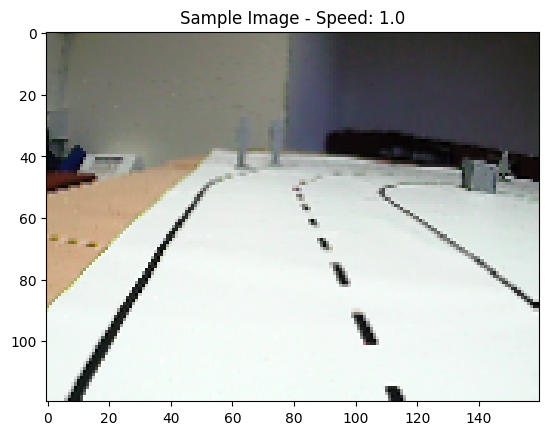


Found 13787 images.
Using 11029 (80.0%) for training.
Using 2758 (20.0%) for validation.
Using 2482 (18.0%) for evaluation of speed.
Using 276 (2.0%) for evaluation of angle.
Length train_set: 11029, Length train labels 11029.
Length val_set: 2758, Length val labels 2758.
Shape of labels: (64,)
Sample labels: [1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] len: 64


In [26]:
# %% [markdown]
# Test/Debug

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:22.490339Z","iopub.execute_input":"2024-03-11T21:51:22.490825Z","iopub.status.idle":"2024-03-11T21:51:23.714168Z","shell.execute_reply.started":"2024-03-11T21:51:22.490789Z","shell.execute_reply":"2024-03-11T21:51:23.712771Z"}}

train_set, val_set, _, _, train_labels, val_labels, _, _ = build_training_validation_and_evaluation_sets(image_paths_cleaned2,
                                                                data_labels_cleaned2,                                     
                                                                   image_shape,
                                                                   batch_size,
                                                                    eval_split,
                                                                   train_val_split  )
# Print the first 10 elements from train_image_paths and data_labels
print("\nFirst 10 elements of train_image_paths:")
for i in range(min(10, len(image_paths_cleaned2))):
    print(image_paths_cleaned2[i])
  # Print the first 10 rows of data_labels
print("\nFirst 10 rows of data_labels:")
print(data_labels_cleaned2.head(10))
    
print(type(train_labels))

train_generator = create_data_generator(train_set, train_labels, batch_size, image_shape, augmentations=datagen, output_label='speed')

val_generator = create_data_generator(val_set, val_labels, batch_size, image_shape, output_label='speed')

# Fetch a single batch from the training generator
for index in range(1):
    sample_batch_images, sample_batch_labels = train_generator[index]

    # Display information about the batch
    print("Sample Batch Information:")
    print(f"Batch Shape - Images: {sample_batch_images.shape}, Labels: {sample_batch_labels['speed'].shape}")
    # Get the file path of the first sample in the batch

    # Optionally, display some samples from the batch
    if len(sample_batch_images) > 0:
        # Display the first sample image
        plt.imshow(sample_batch_images[0])
        plt.title(f"Sample Image - Speed: {sample_batch_labels['speed'][0]}")
        plt.show()

    else:
        print("No samples in the batch.")
    
# Create custom data generators
train_set, val_set, _, _, train_labels, val_labels, _, _ = build_training_validation_and_evaluation_sets(
    image_paths_cleaned2, data_labels_cleaned2, image_shape, batch_size, eval_split, train_val_split
)


print(f"Length train_set: {len(train_set)}, Length train labels {len(train_labels)}.")
print(f"Length val_set: {len(val_set)}, Length val labels {len(val_labels)}.")

train_generator = create_data_generator(train_set, train_labels, batch_size, image_shape, augmentations=datagen, output_label='speed')
val_generator = create_data_generator(val_set, val_labels, batch_size, image_shape, output_label='speed')

# Get a batch from the training generator
sample_images, sample_labels = train_generator[0]

# Print the shape and values of labels
print(f"Shape of labels: {sample_labels['speed'].shape}")
print("Sample labels:", sample_labels['speed'], "len:", len(sample_labels['speed']))

In [27]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:24.118816Z","iopub.execute_input":"2024-03-11T21:51:24.119785Z","iopub.status.idle":"2024-03-11T21:51:24.137540Z","shell.execute_reply.started":"2024-03-11T21:51:24.119745Z","shell.execute_reply":"2024-03-11T21:51:24.136336Z"}}
# Create custom data generators
train_set_data, val_set_data, _, _, train_labels_data, val_labels_data, _, _ = build_training_validation_and_evaluation_sets(image_paths_cleaned2,
                                                                  data_labels_cleaned2,                                     
                                                                   image_shape,
                                                                   batch_size,
                                                                    eval_split,
                                                                   train_val_split  )


train_generator_speed = create_data_generator(train_set_data, train_labels_data, batch_size, image_shape, augmentations=datagen, output_label='speed')
val_generator_speed = create_data_generator(val_set_data, val_labels_data, batch_size, image_shape, output_label='speed')




Found 13787 images.
Using 11029 (80.0%) for training.
Using 2758 (20.0%) for validation.
Using 2482 (18.0%) for evaluation of speed.
Using 276 (2.0%) for evaluation of angle.


In [28]:
# %% [markdown]
# Test/ Debug

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:25.498523Z","iopub.execute_input":"2024-03-11T21:51:25.499383Z","iopub.status.idle":"2024-03-11T21:51:26.239888Z","shell.execute_reply.started":"2024-03-11T21:51:25.499344Z","shell.execute_reply":"2024-03-11T21:51:26.237272Z"}}
print(train_set_data[0])
print(train_labels_data.iloc[[0]])
print(type(train_set_data),type(val_labels_data))


print(f"Length train_set: {len(train_set)}, Length train labels {len(train_labels)}.")
print(f"Length val_set: {len(val_set)}, Length val labels {len(train_labels)}.")

# Check the first batch of the training generator
#sample_batch = next(train_generator_speed)
#print(f"Sample batch shape: {sample_batch[0].shape}")
#print(f"Sample batch labels: {sample_batch[1]}")

# Check the first batch of the validation generator
#sample_val_batch = next(val_generator_speed)
#print(f"Sample validation batch shape: {sample_val_batch[0].shape}")
#print(f"Sample validation batch labels: {sample_val_batch[1]}")

/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10311.png
       image_id   angle  speed
10300     10311  0.4375    1.0
<class 'list'> <class 'pandas.core.frame.DataFrame'>
Length train_set: 11029, Length train labels 11029.
Length val_set: 2758, Length val labels 11029.


In [29]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T21:51:27.436805Z","iopub.execute_input":"2024-03-11T21:51:27.437269Z","iopub.status.idle":"2024-03-11T22:06:49.895017Z","shell.execute_reply.started":"2024-03-11T21:51:27.437234Z","shell.execute_reply":"2024-03-11T22:06:49.892106Z"}}
# Fit the model for 'speed'
history_speed = model_speed.fit(
    train_generator_speed,
    epochs=epochs,
    validation_data=val_generator_speed,
    verbose=1  # Set verbose to 0 to disable the default progress bar
)
# Save the compiled model and trained.
model_speed.trainable = False
model_speed.save('full_CNN_model_speed_trained.h5')

Epoch 1/100
  2/173 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.4844 - auc: 0.4541 - loss: 0.6994 - mae: 0.4841 - mse: 0.2500 - precision: 0.7203 - recall: 0.5326   

I0000 00:00:1710263253.906998     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710263253.927619     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.6977 - auc: 0.5092 - loss: 0.6400 - mae: 0.4437 - mse: 0.2223 - precision: 0.7479 - recall: 0.8995

W0000 00:00:1710263382.663421     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/173 ━━━━━━━━━━━━━━━━━━━━ 176s 877ms/step - accuracy: 0.6979 - auc: 0.5093 - loss: 0.6398 - mae: 0.4436 - mse: 0.2222 - precision: 0.7479 - recall: 0.8998 - val_accuracy: 0.7498 - val_auc: 0.7238 - val_loss: 0.5204 - val_mae: 0.3704 - val_mse: 0.1772 - val_precision: 0.7498 - val_recall: 1.0000
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 801ms/step - accuracy: 0.7558 - auc: 0.7382 - loss: 0.4872 - mae: 0.3251 - mse: 0.1597 - precision: 0.7573 - recall: 0.9973 - val_accuracy: 0.7498 - val_auc: 0.9603 - val_loss: 0.3153 - val_mae: 0.2090 - val_mse: 0.1028 - val_precision: 0.7498 - val_recall: 1.0000
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 804ms/step - accuracy: 0.7519 - auc: 0.9111 - loss: 0.3701 - mae: 0.2341 - mse: 0.1144 - precision: 0.7531 - recall: 0.9978 - val_accuracy: 0.7498 - val_auc: 0.9723 - val_loss: 0.2945 - val_mae: 0.1754 - val_mse: 0.0965 - val_precision: 0.7498 - val_recall: 1.0000
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 803ms/step - accuracy: 0.8371 - a

In [41]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:08:31.984694Z","iopub.execute_input":"2024-03-11T22:08:31.985134Z","iopub.status.idle":"2024-03-11T22:08:32.749345Z","shell.execute_reply.started":"2024-03-11T22:08:31.985088Z","shell.execute_reply":"2024-03-11T22:08:32.748120Z"}}
# Create custom data generators
#train_generator_angle = create_data_generator(train_set_data, train_labels_data, batch_size, image_shape, augmentations=datagen, output_label='angle')
#val_generator_angle = create_data_generator(val_set_data, val_labels_data, batch_size, image_shape, output_label='angle')

# Check the first batch of the training generator
sample_batch = next(train_generator_speed)
print(f"Sample batch shape: {sample_batch[0].shape}")
print(f"Sample batch labels: {sample_batch[1]}")

## Check the first batch of the validation generator
#sample_val_batch = next(val_generator_angle)
#print(f"Sample validation batch shape: {sample_val_batch[0].shape}")
#print(f"Sample validation batch labels: {sample_val_batch[1]}")



Sample batch shape: (64, 120, 160, 3)
Sample batch labels: {'speed': array([1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


In [31]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:09:01.231914Z","iopub.execute_input":"2024-03-11T22:09:01.232464Z","iopub.status.idle":"2024-03-11T22:23:49.249980Z","shell.execute_reply.started":"2024-03-11T22:09:01.232424Z","shell.execute_reply":"2024-03-11T22:23:49.248710Z"}}
# Fit the model for 'angle'
#history_angle = model_angle.fit(
 #   train_generator_angle,
  #  epochs=epochs,
   # validation_data=val_generator_angle,
    #verbose=1  # Set verbose to 0 to disable the default progress bar
#)
# Save the compiled models and trained.
#model_angle.trainable = False
#model_angle.save('full_CNN_model_angle_trained.h5')


In [42]:
# %% [markdown]
# # Test on test data, make submission file!

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:38:12.020114Z","iopub.execute_input":"2024-03-11T22:38:12.020964Z","iopub.status.idle":"2024-03-11T22:38:12.030324Z","shell.execute_reply.started":"2024-03-11T22:38:12.020926Z","shell.execute_reply":"2024-03-11T22:38:12.029116Z"}}
def load_test_images(test_data_dir, image_size=(200, 200)):
    test_images = []
    image_ids = []

    for filename in os.listdir(test_data_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(test_data_dir, filename)
            img = Image.open(image_path)
            # Convert to RGB mode with 24-bit depth
            img = img.convert('RGB')

            # Resize the image to the specified size
            img = img.resize(image_size)
            
            # Convert the PIL Image to a NumPy array
            img_array = np.array(img)
            
            # Ensure the shape is (height, width, channels)
            if img_array.shape[-1] != 3:
                img_array = np.transpose(img_array, (1, 0, 2))  # Swap height and width

            test_images.append(img_array)
            image_ids.append(filename.split(".")[0])  # Extracting the image ID from the filename

    return np.array(test_images), image_ids

In [43]:
# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:38:12.694498Z","iopub.execute_input":"2024-03-11T22:38:12.695387Z","iopub.status.idle":"2024-03-11T22:38:12.702864Z","shell.execute_reply.started":"2024-03-11T22:38:12.695345Z","shell.execute_reply":"2024-03-11T22:38:12.700650Z"}}
print(build_test_directory_img(dataset_path))

/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data


In [47]:

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:38:12.694498Z","iopub.execute_input":"2024-03-11T22:38:12.695387Z","iopub.status.idle":"2024-03-11T22:38:12.702864Z","shell.execute_reply.started":"2024-03-11T22:38:12.695345Z","shell.execute_reply":"2024-03-11T22:38:12.700650Z"}}
print(build_test_directory_img(dataset_path))

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:45:28.784013Z","iopub.execute_input":"2024-03-11T22:45:28.784439Z","iopub.status.idle":"2024-03-11T22:45:28.793583Z","shell.execute_reply.started":"2024-03-11T22:45:28.784409Z","shell.execute_reply":"2024-03-11T22:45:28.791956Z"}}
#def test_cnn_model(model_speed, model_angle, dataset_path, target_size = (int(240/2), int(320/2))):
def test_cnn_model( model_speed, dataset_path, target_size = (int(240/2), int(320/2))):
    # Load test data
    test_images, image_ids = load_test_images(dataset_path, target_size)

    # Make predictions using the trained model

    predictions_speed  = model_speed.predict(test_images)

    print(f" Speed: {predictions_speed }")
    # Flatten the nested lists
  
    flat_predictions_speed = [item for sublist in predictions_speed for item in sublist]
    # Create a DataFrame with image IDs and predictions
    results_df = pd.DataFrame({'image_id': image_ids, 'speed': flat_predictions_speed})
    print(results_df)
     # Save the results DataFrame to the new submission file
    results_df.to_csv('Test_submission_speed.csv', index=False)

/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data


In [48]:

# %% [code] {"execution":{"iopub.status.busy":"2024-03-11T22:45:30.380872Z","iopub.execute_input":"2024-03-11T22:45:30.382074Z","iopub.status.idle":"2024-03-11T22:45:53.270234Z","shell.execute_reply.started":"2024-03-11T22:45:30.382025Z","shell.execute_reply":"2024-03-11T22:45:53.269172Z"}}
test_img_dir = build_test_directory_img(dataset_path)
test_cnn_model( model_speed,test_img_dir, image_shape )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 Speed: [[1.        ]
 [1.        ]
 [1.        ]
 ...
 [0.05035575]
 [0.05035575]
 [0.05035575]]
     image_id     speed
0        1017  1.000000
1         641  1.000000
2         173  1.000000
3         815  1.000000
4         491  1.000000
...       ...       ...
1015      981  0.050356
1016      948  0.050356
1017      306  0.050356
1018      497  0.050356
1019      304  0.050356

[1020 rows x 2 columns]


In [36]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
plot_loss(history_speed)

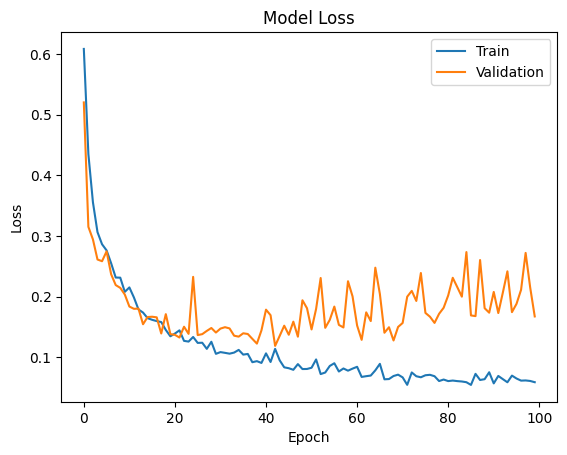

In [40]:

# Get the list of files in the working directory
files_in_working_directory = os.listdir('/kaggle/working/')

# Print the list of files
print(files_in_working_directory)

['state.db', 'full_CNN_model_speed_trained.h5', 'full_CNN_model_speed.h5', '.virtual_documents', 'Test_submission_speed.csv', 'metrics_config_angle.json', 'metrics_config_speed.json']


In [ ]:
print